## Goal of Analysis

### 1. evaluate whether a pricing test running on the site has been successful

### 2. pay special attention on user segmentation and provide insights about segments who behave differently

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
user = pd.read_csv('user_table.csv')
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [3]:
user.dtypes

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object

In [4]:
test = pd.read_csv('test_results.csv', parse_dates = ['timestamp'])
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [5]:
test.dtypes

user_id              int64
timestamp           object
source              object
device              object
operative_system    object
test                 int64
price                int64
converted            int64
dtype: object

In [6]:
user.shape, test.shape

((275616, 5), (316800, 8))

### Part 1: Data preprocessing

In [7]:
full_data = pd.merge(left = user, right = test, how = 'right', on = 'user_id')
full_data.head()

,user_id,city,country,lat,long,timestamp,source,device,operative_system,test,price,converted
0,604839,Buffalo,USA,42.89,-78.86,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,Lakeville,USA,44.68,-93.24,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,Parma,USA,41.38,-81.73,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,Fayetteville,USA,35.07,-78.90,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,Fishers,USA,39.95,-86.02,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [8]:
full_data.shape

(316800, 12)

The user table and the test table records do not match, we will further take a look at this

In [9]:
full_data[['user_id', 'price', 'test']].groupby(['test', 'price']).count()

user_id
test price         
0    39      202517
     59         210
1    39         155
     59      113918

The label 0 on test means 39 dollars and label 1 means 59 dollars. But actually there are some customers with label 0 see price 59 dollars and some customers with label 1 see price 39 dollars. The could cause a problem to our test.

Since the total amount of those problematic data is only a small portion of the dataset, we will remove those data

In [10]:
# only keep the valid data
full_data = full_data[((full_data['test']==0) & (full_data['price']==39)) | 
                      ((full_data['test']==1) & (full_data['price']==59))]

### Part 2: EDA

I will make the plot for the three key factors: source, device, and operative systems

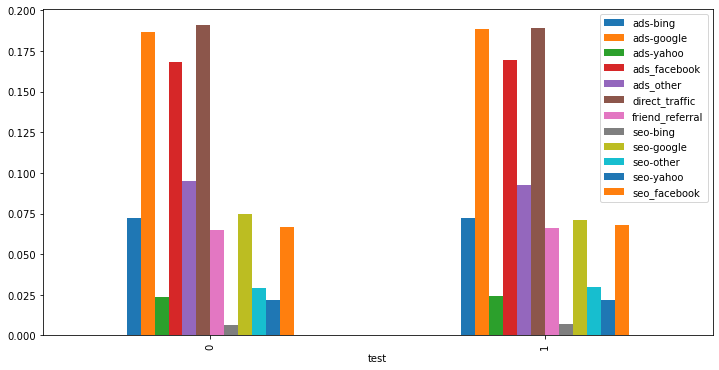

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# for source

source_plot = full_data.groupby('test')['source'].apply(lambda x: x.value_counts(normalize=True)).unstack()

fig, ax = plt.subplots(figsize=(12, 6))
source_plot.plot(kind='bar', ax=ax)
plt.show()

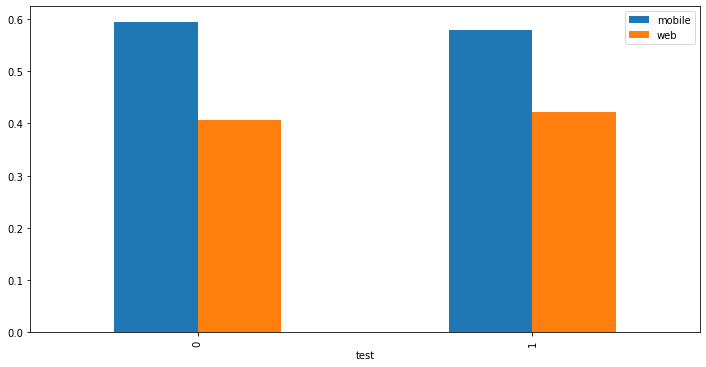

In [12]:
# for device

device_plot = full_data.groupby('test')['device'].apply(lambda x: x.value_counts(normalize=True)).unstack()
fig, ax = plt.subplots(figsize=(12, 6))
device_plot.plot(kind='bar', ax=ax)
plt.show()

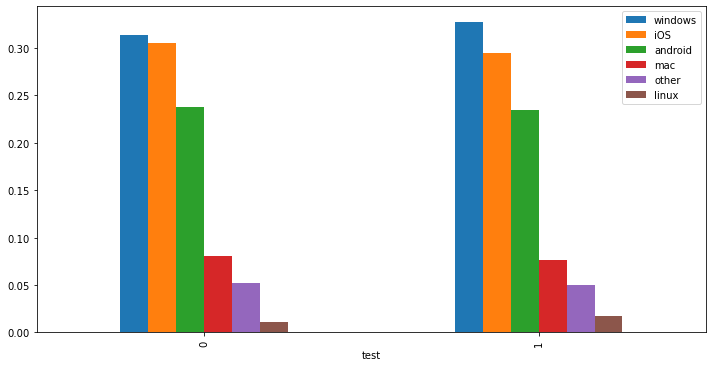

In [13]:
# operative_system

operative_system_plot = full_data.groupby('test')['operative_system'] \
.apply(lambda x: x.value_counts(normalize=True)).unstack()

fig, ax = plt.subplots(figsize=(12, 6))
operative_system_plot.plot(kind='bar', ax=ax)
plt.show()

It seems that the test for device and operating system has some differences

### Part 3: Evaluate the pricing test

first, we should take a look at the conversion rate for each test

In [14]:
# check the conversion rate for A/B test
full_data[['test', 'converted']].groupby('test').mean()

,converted
test,
0,0.019900
1,0.015555


For those with lower price of $ 39, they have a higher conversion rate of 1.99%. 

For those with higher price of $ 59, they have a lower conversion rate of 1.55% .

Next we will evaluate the converted rate for each of source, device, and operating systems

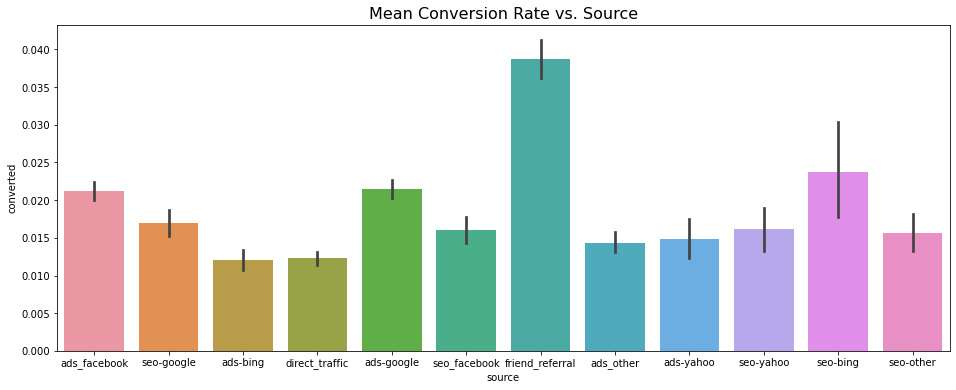

In [15]:
# for source

fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=full_data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Source', fontsize=16)
plt.show()

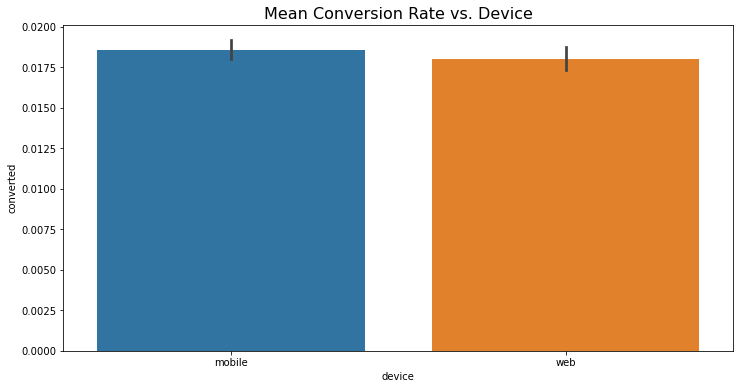

In [16]:
# for device

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='device', y='converted', data=full_data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Device', fontsize=16)
plt.show()

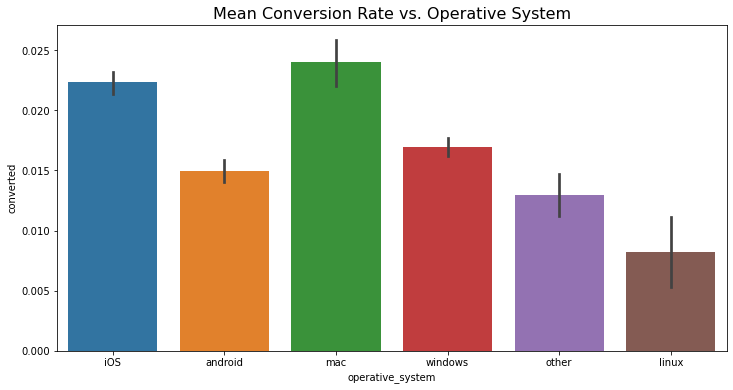

In [17]:
# for operative system

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='operative_system', y='converted', data=full_data, ax=ax)
ax.set_title('Mean Conversion Rate vs. Operative System', fontsize=16)
plt.show()

Insights:

we can see from the graph that:

1. friend referral is the most important source for conversion, so word of mouth is very important to our business

2. mobile device has a slightly higher conversion rate than web, we should place some promotions on mobile to boost it

3. Mac and IOS operating system have higher conversion rate than others, which may indicate apple users are more likely to make purchase on us